In [2]:
# make the notebook more readable:
import warnings; warnings.filterwarnings('ignore')
# add location of user modules to PYTHONPATH
import sys,os
module_path = os.path.join(os.getcwd(), '../submodules/')
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)

In [3]:
import xarray as xr
import numpy  as np
import file_handling as fh

def masked_file_list(directory, mask):
    return [os.path.join(directory, f) for f in fh.get_filelist(directory) if mask in f]

def dataset_from_directory(directory, mask = 'DOM01_surf', rename_dict={'ncells':'cell'}, convert_time=True, clear_dims=False):
    data = xr.open_mfdataset(masked_file_list(directory, mask))
    if rename_dict: data = data.rename(rename_dict)
    if convert_time: data = data.assign_coords({"time": icontime2numpytime(data.time.values)})
    if clear_dims:   data = remove_dims(data, clear_dims)
    return data.rename()

def remove_dims(data, dims={'height':10, 'height_2':2}):
    for key, value in dims.items():
        data = data.sel({key:value}).drop(key)
    return data

def single_icontime2numpytime(timefloat):
    date_string = str(int(timefloat))
    h_ = 24 * (timefloat - int(timefloat))
    h  = int(h_)
    m_ = 60 * (h_ - h)
    m  = int(np.round(m_))
    if m == 60: m = 0; h += 1
    return np.datetime64(f'{date_string[0:4]}-{date_string[4:6]}-{date_string[6:8]}T{str(h).rjust(2,"0")}:{str(m).rjust(2,"0")}')

def is_iterable(x):
    try:    len(x); return True
    except: return False

def icontime2numpytime(timefloat):
    if is_iterable(timefloat): 
        return np.asarray([icontime2numpytime(t) for t in timefloat])
    else: return single_icontime2numpytime(timefloat)

def print_overview(data, title, dims=['cell', 'time']):
    print('-' * (14+13+9+9+4))
    print(title)
    print('short name'.ljust(14), 'mean'.rjust(12), 'min'.rjust(10), 'max'.rjust(10) )
    print('-' * (14+13+9+9+4))
    for var in list(data):
        mean = data[var].mean(dim=dims, skipna=True).values
        if is_iterable(mean): mean = mean[0]
        mini = data[var].min(dim=dims, skipna=True).values
        if is_iterable(mini): mini = mini[0]
        maxi = data[var].max(dim=dims, skipna=True).values
        if is_iterable(maxi): maxi = maxi[0]
        print(var.ljust(14), f'{mean:.2f}'.rjust(12), f'{mini:.2f}'.rjust(10), f'{maxi:.2f}'.rjust(10))
    print()

def get_path(experiment):
    # if   experiment == 'warming': return '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/4kadiabat'
    if   experiment == 'warming': return '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/4kadiabat2'
    elif experiment == 'rerun'  : return '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/r02EUREC4A'

def radiation_data(experiment):
    dat  = dataset_from_directory(get_path(experiment), mask='DOM01_rad', rename_dict={'ncells':'cell'}, convert_time=True)
    drops = ['ddt_temp_radsw','ddt_temp_radlw','lwflx_dn_clr','lwflx_dn','lwflx_up_clr','lwflx_up']
    return dat.drop_vars(drops).drop_dims('height_2')

def surface_data(experiment):
    # if experiment == 'control': 
    #     return cat.simulations.ICON.LES_CampaignDomain_control['surface_DOM01'].to_dask()
    data = dataset_from_directory(get_path(experiment) , convert_time=True, rename_dict={'ncells':'cell'})
    data = data.sel(height=10).sel(height_2=2).drop_vars(['height', 'height_2'])
    return data

def overlap_timesteps(datasets):
    t = datasets[0].time.values
    for dataset in datasets[1::]:
        t = [x for x in t if x in dataset.time.values]
    return t

def time_overlap(datasets):
    t = overlap_timesteps(datasets)
    return tuple([d.sel(time=t) for d in datasets])

In [4]:
r = surface_data('rerun')
w = surface_data('warming')

# # print_overview(r, 'RERUN')
# # print_overview(w, '4K adiabatic warming')
# print_overview(w-r, 'warming - control')

```
-------------------------------------------------
warming - control
short name             mean        min        max
-------------------------------------------------
u_10m                 -0.36     -19.71      19.93
v_10m                 -0.17     -21.03      20.78
rh_2m                  0.05      -0.52       0.57
t_2m                   3.11      -4.65       8.44
qv_2m                  0.00      -0.01       0.01
t_seasfc               4.00       4.00       4.00
shfl_s               -17.71    -585.71     799.25
lhfl_s               -90.13   -1282.85    1001.57
tqv_dia                8.94     -19.08      47.73
tqc_dia                0.05     -15.32      16.71
tqi_dia                0.00      -3.85       5.27
rain_gsp_rate          0.00      -0.07       0.10
tot_prec               0.53     -45.48      90.00
clct                  14.82    -100.00     100.00
pres_sfc           -1672.22   -2701.24     114.38
```

## Are the initial conditions ok?
The energy fluxes have different signs in rerun and warming experiment. This is alarming and might point to failed initialisation. Let us double check the `initc` file.

In [4]:
def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

initc_w = xr.open_dataset('/work/mh1126/m300872/moist_adiabatic/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc')
initc_r = xr.open_dataset('/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc')
diff_profile = initc_w['t'].mean(dim=['time','ncells']) - initc_r['t'].mean(dim=['time','ncells'])
p = initc_w['p'].mean(dim=['time','ncells'])
h = interpolate_full_level(initc_w['z_ifc'].mean(dim=['time','ncells']).values)

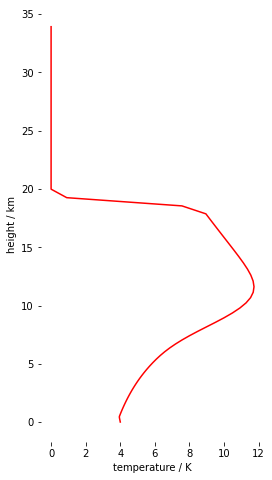

In [5]:
import matplotlib.pyplot as plt
import plot_utils as pu
fig, ax = plt.subplots(figsize=(4,8))
# ax.plot(diff_profile, p/100, color='red')
ax.plot(diff_profile, h/1000, color='red')
ax.set_xlabel('temperature / K')
# ax.set_ylabel('pressure / hPa')
ax.set_ylabel('height / km')
# ax.invert_yaxis()
pu.remove_spines(ax)
plt.show()

This looks good. I have to check if I should have provided `theta_v` and `rho` for the initial field.

## Temporal evolution of (near surface) air temperatures

The mean temperature difference is less than the prescribed one. This could mean that the domain is cooling after it initialised, or that it is initialised cool and then begins to warm. A timeseries of 2m air temperature should resolve this question.

In [5]:
r = surface_data('rerun')
w = surface_data('warming')
r_series = (r.time.values, r['t_2m'].mean(dim=['cell']).values)
w_series = (w.time.values, w['t_2m'].mean(dim=['cell']).values)

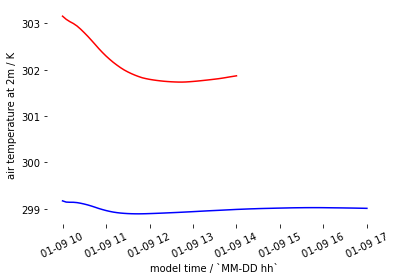

In [9]:
import matplotlib.pyplot as plt
import plot_utils as pu

fig, ax = plt.subplots()#figsize=(4,8))
ax.plot(*r_series, color='blue')
ax.plot(*w_series, color='red')
ax.set_xlabel('model time / `MM-DD hh`')
ax.set_ylabel('air temperature at 2m / K')
# ax.invert_yaxis()
# ax.set_xticklabels(ax.get_xticks(), rotation = -45)
pu.remove_spines(ax)
plt.xticks(rotation = 25)
fig.savefig('./img/t2m_timeseries_rerun_warming.png')
plt.show()

The start of the time series fits the initial conditions, but the domain is then rapidly cooled by several degree.

In [8]:
x = xr.open_dataset('/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc')['t'].mean(dim=['time','ncells'])
print('temp    heigth')
for i in [74,73,72]:
    print(f'{x.values[i]:.2f}  {h[i]:.0f}m')

temp    heigth
298.83  10m
298.46  40m
298.00  87m


## Radiation output

In [9]:
# cold_surf_files = [os.path.join('/',f) for f in get_filelist('../../../../..',conserved=os.path.join('/',dir_warm,'')) if 'surf' in f]
# warm_surf_files = [os.path.join('/',f) for f in get_filelist('../../../../..',conserved=os.path.join('/',dir_cold,'')) if 'surf' in f]
# len(cold_surf_files),len(warm_surf_files)

## Temperature profile

In [10]:
w = dataset_from_directory('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/4kadiabat2', mask='DOM01_3D',
                           rename_dict={'ncells':'cell'}, convert_time=True)#, clear_dims={'height':10, 'height_2':2})
w_temp = w['temp'].mean(dim=['cell','time']).values
w_pres = w['pres'].mean(dim=['cell','time']).values
r = dataset_from_directory('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/r02EUREC4A', mask='DOM01_3D',
                           rename_dict={'ncells':'cell'}, convert_time=True)#, clear_dims={'height':10, 'height_2':2})
r_temp = r['temp'].mean(dim=['cell','time']).values
r_pres = r['pres'].mean(dim=['cell','time']).values

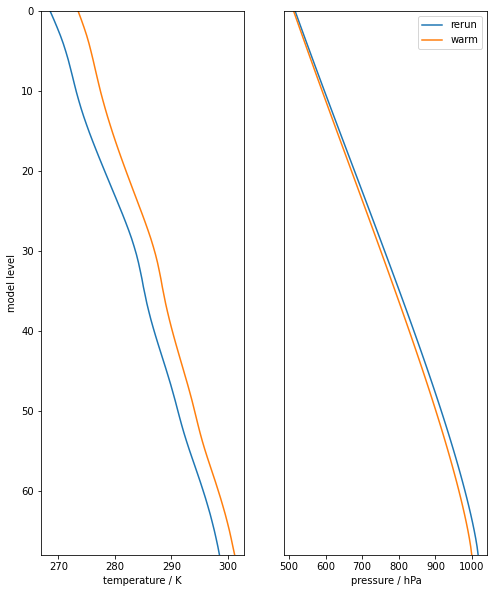

In [11]:
import matplotlib.pyplot as plt
import plot_utils as pu

fig, axs = plt.subplots(1,2, figsize=(8,10))
ax = axs[0]
levels = np.linspace(0,68,68)
ax.plot(r_temp, levels, label='rerun')
ax.plot(w_temp, levels, label='warm')
ax.invert_yaxis()
ax.set_xlabel('temperature / K')
ax.set_ylabel('model level')
ax.set_ylim(levels[-1], levels[0])
ax = axs[1]
ax.plot(r_pres / 100, levels, label='rerun')
ax.plot(w_pres / 100, levels, label='warm')
ax.invert_yaxis()
ax.set_xlabel('pressure / hPa')
ax.set_ylim(levels[-1], levels[0])
pu.remove_ticks(ax,['left','right'])
ax.legend()
plt.show()

## Meteogram temperature timeseries

## Is cold air coming from the boundaries?

The meteogram at BCO shows how after initialisation the lower (ca. 100) levels get colder, while the upper levels get warmer. To make sure this is not cause by too cold air moving in from the boundaries, we will double check them. first a few random profiles.

In [ ]:
import random 
import matplotlib.pyplot as plt
import xarray as xr
import file_handling as fh
import numpy as np

def latbc_random_file(latbc_directory='/work/mh1126/m300872/unchanged/'):
    file_list = fh.get_filelist(latbc_directory, 'latbc/')
    file = random.choice(file_list)
    return file

def latbc_random_pair(latbc_directories=
    ('/work/mh1126/m300872/unchanged/', '/work/mh1126/m300872/moist_adiabatic/')):
    filename = latbc_random_file(latbc_directories[0])
    a = xr.open_dataset(os.path.join(latbc_directories[0], filename))
    b = xr.open_dataset(os.path.join(latbc_directories[1], filename))
    return a,b

def latbc_random_diff(latbc_directories=
    ('/work/mh1126/m300872/unchanged/', '/work/mh1126/m300872/moist_adiabatic/')):
    a, b = latbc_random_pair(latbc_directories)
    return b - a

def ax_temp_delta(ax):
    data = latbc_random_diff()
    lvl = data.temp.height_3.values

    ax.set_title(f'latbc delta at {str(data.time.values[0])[0:19]}')

    axs = [ax, ax.twiny()]
    variables = ('temp', 'qv')
    colors    = ('tab:orange', 'tab:blue')
    labels    = ('temperature / K', 'specific moisture')

    for ax, var, color, label in zip(axs, variables, colors, labels):    
        x = np.ravel(data[var].mean(dim='ncells').values)
        ax.set_ylim(lvl[-1],lvl[0])
        ax.plot(x, lvl, color=color)
        ax.set_xlabel(label, color=color)
        ax.tick_params(axis='x', colors=color)
    axs[0].set_ylabel('model level')
    return axs

n_plots = 4
fig, axs = plt.subplots(1,n_plots, figsize=(4 * n_plots, 8))
for i in range(n_plots):
    ax_temp_delta(axs[i])
fig.show()

And now over a continuous time frame

In [ ]:
import file_handling as fh
import xarray as xr

def latbc_temp_mean_timeseries(latbc_directory):
    file_list = fh.get_filelist('', latbc_directory+'latbc/')
    chunks = list()
    # for i in range(int(len(latbc_files)/10)): # for (almost) the whole thing
    for i in range(8): # for the first 50 timesteps 
        i = i * 10
        chunks.append(xr.open_mfdataset(file_list[i:i+10])['temp'].mean(dim='ncells'))
    return xr.merge(chunks)

control = '/work/mh1126/m300872/unchanged/'
warming = '/work/mh1126/m300872/moist_adiabatic/'
data = latbc_temp_mean_timeseries(warming).temp.values - latbc_temp_mean_timeseries(control).temp.values

# fig, ax = plt.subplots()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.imshow(data.transpose())
ax.set_xlabel('timesteps')
ax.set_ylabel('vertical level')
ax.set_title('')

In [10]:
import plot_utils as pu

def plot_scatter_var(data, varname, timestep):
    s = data[varname].isel(time=timestep)
    fig, ax = plt.subplots()
    lon = np.rad2deg(s.clon)
    lat = np.rad2deg(s.clat)
    ax.scatter(lon, lat, c=s, s=0.1)
    ax.set_xlim(np.min(lon),np.max(lon))
    ax.set_ylim(np.min(lat),np.max(lat))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{varname} : {str(s.time.values)[0:19]}')
    pu.remove_spines(ax)
    return fig, ax

def eureca_grid(domain='DOM01'):
    return xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{domain}.zarr")

def add_grid(dataset, grid, drop_vars=True, drop_dims=True):
    gridvars = list(grid)
    d = xr.merge([dataset,grid])
    if drop_vars:
        d = d.drop_vars(gridvars)
    if drop_dims:
        d = d.sel(edge=0, drop=True)
        d = d.sel(vertex=0, drop=True)
    return d

def create_frames(dataset, varname, indices=False, verbose=False):
    if not indices: indices = range(len(dataset.time.values))
    file_list = list()
    for i in indices:
        file_name = f'/scratch/m/m300872/temp/deletethis_{varname}-{str(i).rjust(2,"0")}.jpg'
        if verbose: print(i, file_name)
        file_list.append(file_name)
        fig, ax = plot_scatter_var(dataset, varname, i)
        fig.savefig(file_name)
        plt.close(fig)
    return file_list
        
dataset = add_grid(radiation_data('warming'), eureca_grid())
varname = 'sou_t'
# file_list = create_frames(dataset, varname)
# print(len(file_list))
dataset[varname]

<xarray.DataArray 'sou_t' (time: 25, cell: 4528560)>
dask.array<concatenate, shape=(25, 4528560), dtype=float32, chunksize=(6, 4528560), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-09T10:00:00 ... 2020-01-09T14:00:00
    clat     (cell) float64 dask.array<chunksize=(1132140,), meta=np.ndarray>
    clon     (cell) float64 dask.array<chunksize=(1132140,), meta=np.ndarray>
Dimensions without coordinates: cell
Attributes:
    standard_name:                sou_t
    long_name:                    shortwave upward flux at TOA
    units:                        W m-2
    param:                        8.4.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1
    level_type:                   toa

In [11]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import glob

def gif_from_image_list(file_list, save_name=False, delete_frames=False):
    if not save_name: f'generated_clip_{len(file_list)}-frames.gif'
    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img, *imgs = [Image.open(f) for f in file_list]
    img.save(fp=save_name, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)
    if delete_frames:
        for file in file_list: os.remove(file)
    return save_name

varname = 'sou_t'
save_name = f'img/{varname}.gif'
# gif_from_image_list(file_list, save_name)

![](img/sou_t.gif)

In [12]:
varname = 'thb_t'
file_list = create_frames(dataset, varname)
# gif_from_image_list(file_list, f'img/{varname}.gif')

![](./img/thb_t.gif)

In [13]:
dataset = add_grid(surface_data('warming'), eureca_grid())
dataset = add_grid(surface_data('rerun'), eureca_grid())
varname = 'clct'
# file_list = create_frames(dataset, varname)
# print(len(file_list))
dataset[varname]

<xarray.DataArray 'clct' (time: 85, cell: 4528560)>
dask.array<concatenate, shape=(85, 4528560), dtype=float32, chunksize=(1, 4528560), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-09T10:00:00 ... 2020-01-09T17:00:00
    clat     (cell) float64 dask.array<chunksize=(1132140,), meta=np.ndarray>
    clon     (cell) float64 dask.array<chunksize=(1132140,), meta=np.ndarray>
Dimensions without coordinates: cell
Attributes:
    standard_name:                clct
    long_name:                    total cloud cover
    units:                        %
    param:                        1.6.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [14]:
# multi-purpose tools
import numpy as np
import pandas as pd
import intake
import xarray as xr
xr.set_options(keep_attrs=True)
from functools import partial
from function_timer import function_timer

# plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datashader
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf
import cmocean


def proj2coords(grid, projection):
    coords = projection.transform_points(
        ccrs.Geodetic(),
        np.rad2deg(grid.clon),
        np.rad2deg(grid.clat))
    return coords

def draw_domain(ax, variable, coords, vminmax=False, cmap='plasma', spread=None, coastline=False):
    if vminmax:
        vmin, vmax = vminmax
    else:
        vmin = np.min(variable.values); vmax = np.max(variable.values)
    if spread == True:
        spread = partial(dstf.spread, px=2)
    if coastline:
        ax.add_feature(cfeature.COASTLINE, linewidth=3, color='forestgreen')
        
    artist = dsshow(
        pd.DataFrame({
            "val": variable.values,
            "x": coords[:, 0],
            "y": coords[:, 1],
        }),
        datashader.Point('x', 'y'),
        datashader.mean('val'),
        vmin=vmin, vmax=vmax, cmap=cmap,
        ax=ax,
        # https://github.com/holoviz/datashader/issues/1068
        # shade_hook=partial(dstf.dynspread, threshold=0.50, how='over')
        shade_hook=spread
    )
    return artist


def map_plot(dataset, varname, timeindex, 
             vminmax, figsize=(15,10), viewpoint=(-50, 15, 2e6), cmap='viridis'):    
    
    central_longitude, central_latitude, satellite_height = viewpoint
    projection = ccrs.PlateCarree(central_longitude=central_longitude)
    coords = proj2coords(dataset[varname],projection)

    fig, ax = plt.subplots(figsize=figsize,subplot_kw={"projection": projection})
    fig.canvas.draw_idle() # its a bug fix...

    variable = dataset[varname].isel(time=timeindex)
    artist = draw_domain(ax, variable, coords, vminmax=vminmax, cmap=cmap, spread=True, coastline=True)
    fig.colorbar(artist, cax=ax.inset_axes([0.1, 0.1, 0.1, 0.1], zorder=-1), orientation='vertical') 
    ax.set_title(f'{varname} : {str(dataset.isel(time=timeindex).time.values)[0:19]}')
    return fig, ax



def create_frames(dataset, varname, indices=False, verbose=False, prefix='deletethis'):
    if not indices: indices = range(len(dataset.time.values))
    file_list = list()
    for i in indices:
        file_name = f'/scratch/m/m300872/temp/{prefix}_{varname}-{str(i).rjust(2,"0")}.jpg'
        if verbose: print(i, file_name)
        file_list.append(file_name)
        fig, ax = fig, ax = map_plot(dataset, varname, timeindex=i, vminmax=(0,1), cmap=plt.cm.get_cmap('Blues').reversed())
        fig.savefig(file_name)
        plt.close(fig)
    return file_list



dataset = add_grid(surface_data('warming'), eureca_grid())
# dataset = add_grid(surface_data('rerun'), eureca_grid())

file_list = create_frames(dataset, 'clct', prefix='warming')
print(len(file_list))

49


In [15]:
file_list_warming=file_list
save_name = f'img/clct_warming.gif'
gif_from_image_list(file_list_warming, save_name)

'img/clct_warming.gif'

![](./img/clct_warming.gif)

In [16]:
dataset = add_grid(surface_data('rerun'), eureca_grid())
file_list_rerun = create_frames(dataset, 'clct', prefix='rerun')
print(len(file_list_rerun))
save_name = f'img/clct_rerun.gif'
gif_from_image_list(file_list_rerun, save_name)

85


'img/clct_rerun.gif'

![](./img/clct_rerun.gif)

In [39]:
import sys
from PIL import Image
import os

file_list_compare = list()
for  i in range(min(len(file_list_warming), len(file_list_rerun))):
    images = (Image.open(file_list_rerun[i]), Image.open(file_list_warming[i]))
    # create new empty image with dimensions as sum of images
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    # print("new image dimensions: ", total_width, max_height)
    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    # save
    # display(new_im)
    filename = f'/scratch/m/m300872/temp/compare_clct_{str(i).rjust(2,"0")}.png'
    # print(filename)
    new_im.save(filename)
    file_list_compare.append(filename)
print(len(file_list_compare))
save_name = f'img/clct_compare.gif'
gif_from_image_list(file_list_compare, save_name)

49


'img/clct_compare.gif'

![](./img/clct_compare.gif)

In [8]:
filename = '/scratch/m/m300872/temp/compare_clct_48.png'
display(Image.open(filename))

NameError: name 'Image' is not defined

![](./img/clct_compare.gif)

In [ ]:

def map_plot(dataset, varname, timeindex, 
             vminmax, figsize=(15,10), viewpoint=(-50, 15, 2e6), cmap='viridis'):    
    
    central_longitude, central_latitude, satellite_height = viewpoint
    projection = ccrs.PlateCarree(central_longitude=central_longitude)
    coords = proj2coords(dataset[varname],projection)

    fig, ax = plt.subplots(figsize=figsize,subplot_kw={"projection": projection})
    fig.canvas.draw_idle() # its a bug fix...

    variable = dataset[varname].isel(time=timeindex)
    artist = draw_domain(ax, variable, coords, vminmax=vminmax, cmap=cmap, spread=True, coastline=True)
    fig.colorbar(artist, cax=ax.inset_axes([0.1, 0.1, 0.1, 0.1], zorder=-1), orientation='vertical') 
    ax.set_title(f'{varname} : {str(dataset.isel(time=timeindex).time.values)[0:19]}')
    return fig, ax

In [ ]:


import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import datashader
from datashader.mpl_ext import dsshow

import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean

data = xr.open_zarr("https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/dpp0066/R02B06/2d_ml.zarr")
grid = xr.open_zarr("https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/nextGEMS/grids/ICON_R02B06.zarr")

central_longitude = 0
central_latitude = 0
satellite_height = 184759000

vmin = 0
vmax = 600
cmap = cmocean.cm.thermal

variable = data["rlds"].isel(time=1)

projection = ccrs.NearsidePerspective(central_longitude=central_longitude, central_latitude=central_latitude, satellite_height=satellite_height)

coords = projection.transform_points(
    ccrs.Geodetic(),
    np.rad2deg(grid.clon),
    np.rad2deg(grid.clat),
)

fig, ax = plt.subplots(subplot_kw={"projection": projection})
fig.canvas.draw_idle()
ax.add_feature(cf.COASTLINE, linewidth=0.8)

artist = dsshow(
    pd.DataFrame({
        "val": variable.values,
        "x": coords[:, 0],
        "y": coords[:, 1],
    }),
    datashader.Point('x', 'y'),
    datashader.mean('val'),
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    ax=ax,
)

fig.colorbar(artist, label=f"{variable.long_name} / {variable.units}")


## Stability

$$ LTS = \theta (surface) - \theta(700 hPa) $$


In [ ]:
from metpy.units import units
import metpy.calc as mpcalc

def nearest_value_index(array, value):
    # https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/
    difference_array = np.absolute(array-value)
    # index = difference_array.argmin()
    index = np.nanargmin(difference_array)
    return index

def lts(t,p):
    i = nearest_value_index(w_pres, 70000)
    theta_s   = mpcalc.potential_temperature(p[-1] * units('Pa'), t[-1] * units('kelvin'))
    theta_700 = mpcalc.potential_temperature(p[i] * units('Pa'), t[i] * units('kelvin'))
    return (theta_700 - theta_s).magnitude


lts(r_temp, r_pres), lts(w_temp, w_pres)

In [44]:
for dom in ['DOM01','DOM02']:
    grid = xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{dom}.zarr")
    print(dom, grid.cell.values.shape)

DOM01 (4528560,)
DOM02 (11792076,)
